### SSIoT traffic analysis

In [1]:
import pandas as pd
import sys
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


In [2]:
path = "C:\\Users\\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\csv-files\\"
filenames = [f for f in listdir(path) if isfile(join(path, f))]
exclude= ["MiLampStartUp.csv", "MiLampStartUp2.csv"]

In [3]:
# read files and label them accordingly
sametest = []
checked = set()
for file in filenames:
    if file in exclude:
        continue
    same = []
    file = file.split(".")[0]
    for name in filenames:
        if file in name and file != name:
            if name not in checked:
                #name = name.split(".")[0]
                same.append(name)
                checked.add(name)
    if len(same) > 0:
        sametest.append(same)
        
df = pd.DataFrame()

for files in sametest:
    tm = pd.DataFrame()
    for i in range(len(files)):
        tm = pd.concat([tm, pd.read_csv(path + files[i], header=0)],ignore_index=False)
    tm["label"] = str(files[0].split(".")[0])
    df = pd.concat([df,tm], ignore_index=False)
df = df.reset_index(drop=True)

In [7]:
# reformat the timestamp
for i in range(df.shape[0]):
    date = str(df.at[i,"frame.time"]).split(" ")
    if len(date) == 7:
        df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[4])
    else:
        df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[3])


In [53]:
# plots every feature of the given df, except the excluded ones, m are rows and n are the columns of the plot
def plot_stuff(df, exclude,m,n):
    c = 0
    r = 0
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,12))
    for column in df:
        if column in exclude:
            continue
        axs[r, c%n] = df[column].value_counts().plot(kind="barh", ax=axs[r, c%n], title=column)
        #axs[r, c%n].set_title(column)
        # set individual bar lables using above list
        for i in axs[r, c%n].patches:
            # get_width pulls left or right; get_y pushes up or down
            axs[r, c%n].text(i.get_width()+.1, i.get_y()+.2, str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')
        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf()

In [17]:
# show available labels:
df.label.value_counts()

MiLampDecreaseBrightnessInApp    282
MiLampIncreaseTempInApp          229
MiLampDecreaseTempInApp          196
MiLampIncreaseBrightnessInApp    181
MiLampChildMode                   65
MiLampPushTurnButtonLeft          52
MiLampAdjustTempInApp             41
MiLampTurnButtonLeft              41
MiLampTurnButtonRight             36
MiLampTurnOnFocusModeApp          30
MiLampPushTurnButtonRight         27
MiLampDoubleTabButton             26
MiLampAdjustBrightnessInApp       24
MiLampOpenApp                     20
MiLampTurnOnPCModeApp             15
MiLampTurnOffinApp                15
MiLampTurnOninApp                 15
MiLampTurnOffFocusModeApp         14
MiLampTurnOnReadingModeApp        13
MiLampPressOnButtonToTurnOn       13
MiLampOpenSettings                11
MiLampPressOnButtonToTurnOff      10
Name: label, dtype: int64

In [24]:
#select specific test/label
x1 = df.loc[df.label == "MiLampDecreaseBrightnessInApp"]
# drop specific rows
x1 = x1.drop(x1[x1["ip.src"] == "192.168.137.1"].index)

In [29]:
x1.head()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,label
130,1,2020-06-15 10:20:44.582493,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310070000000000721ae555ee5ddda1f2eecdc1f23e5...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
131,2,2020-06-15 10:20:44.752658,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.44,18.197.235.166,17.0,21310040000000000721ae555ee5dddaab4a50bc703085...,64.0,54321.0,8053.0,72.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
132,3,2020-06-15 10:20:44.755314,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.44,18.197.235.166,17.0,21310060000000000721ae555ee5ddda613b63df8adf36...,96.0,54321.0,8053.0,104.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
133,4,2020-06-15 10:20:44.789079,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310040000000000721ae555ee5ddda7fd3210a46cecb...,64.0,8053.0,54321.0,72.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
134,5,2020-06-15 10:20:45.086023,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310070000000000721ae555ee5dddacc9a653bde272a...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp


In [54]:
no_interest = ["frame.number", "frame.time","data.data", "eth.addr.oui_resolved", "label"]

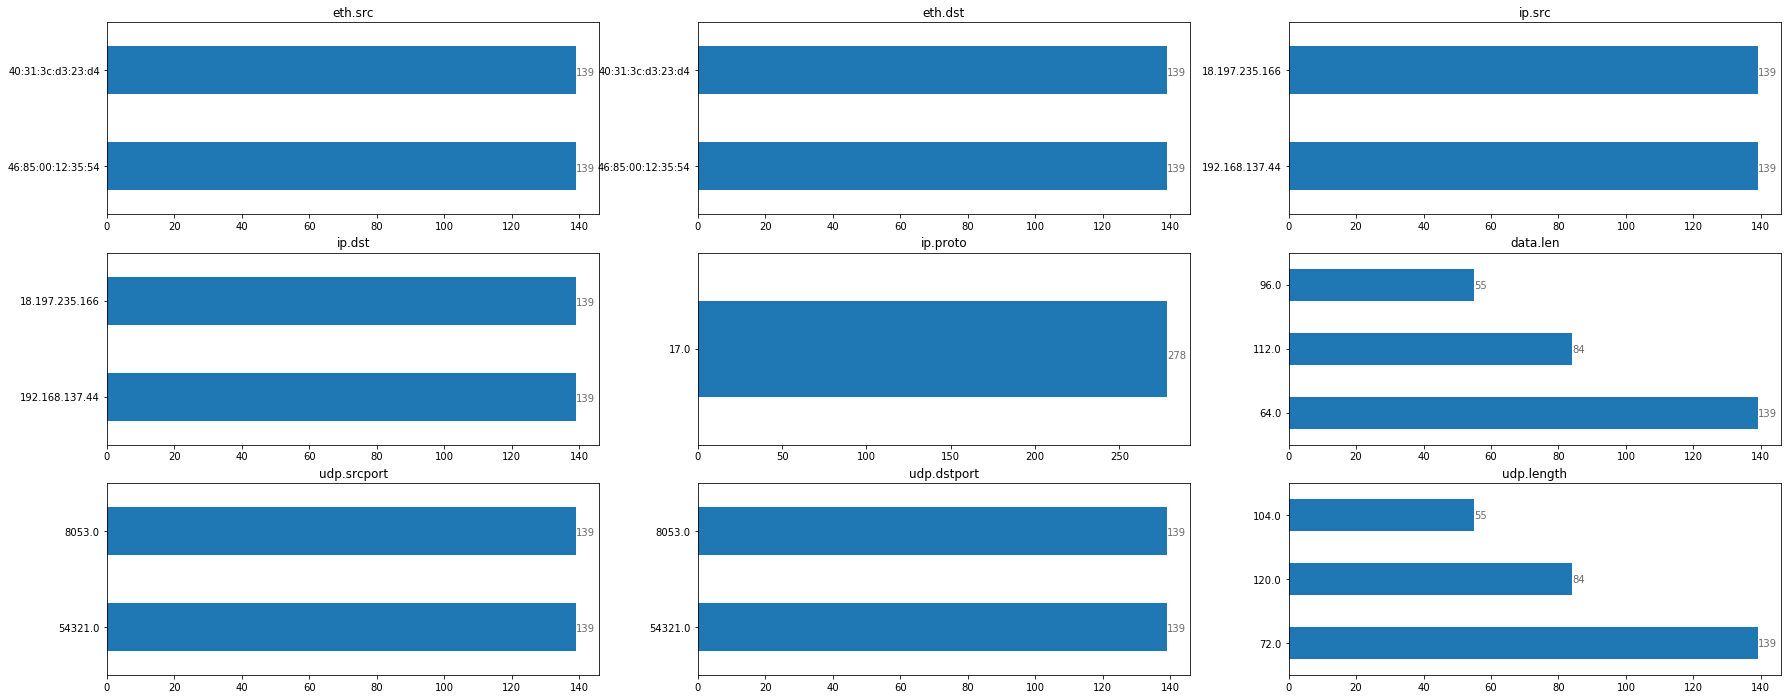

<Figure size 432x288 with 0 Axes>

In [55]:
plot_stuff(x1,no_interest,3,3)

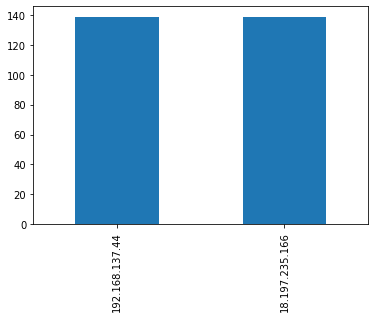

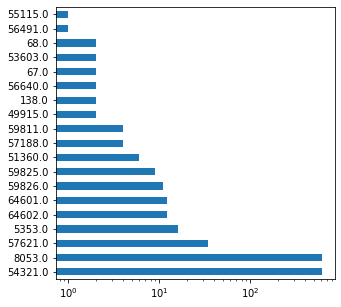

In [12]:
df["udp.srcport"].value_counts().plot(kind="barh", figsize=(5,5), logx=True)

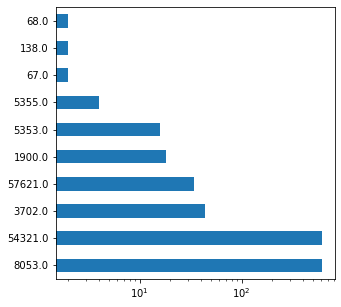

In [13]:
df["udp.dstport"].value_counts().plot(kind="barh", figsize=(5,5), logx=True)

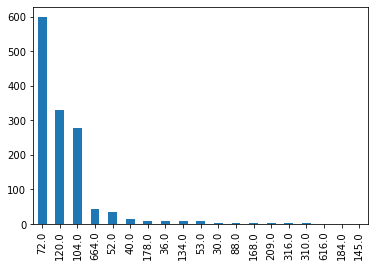

In [14]:
df["udp.length"].value_counts().plot(kind="bar")

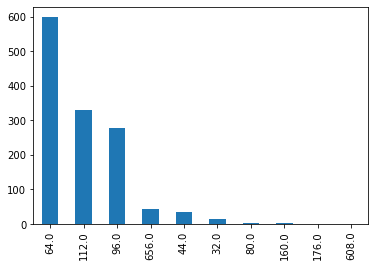

In [15]:
df["data.len"].value_counts().plot(kind="bar")

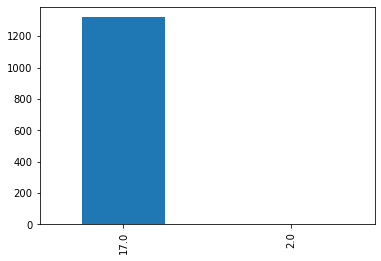

In [18]:
df["ip.proto"].value_counts().plot(kind="bar")

In [79]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier


In [112]:
x = df.drop(columns=["frame.number", 'eth.addr.oui_resolved', "frame.time", "ip.proto"])
x = x.fillna("0")
#Function to encode given features
# input df: dataframe which should be modified
# input features: features that should be encoded
def encode_feature(df, feature):
  feature_enc = LabelEncoder()
  feature_enc.fit(df[feature].to_numpy().astype(str))
  df[feature] = feature_enc.transform(df[feature])

features = ["eth.src", "eth.dst", "ip.src", "ip.dst", "label", "data.data"]

for feat in features:
    encode_feature(x,feat)
y = x["label"]
x = x.drop(columns=["label"])
#x=x["data.data"]
x = x.reset_index(drop=True)

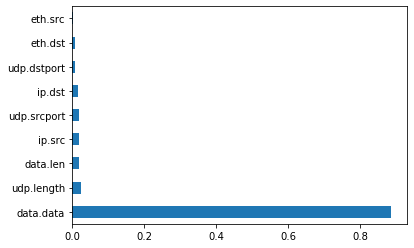

In [113]:
# Show the relevance of each feature
model = ExtraTreesClassifier()
model.fit(x,y.astype('int').ravel())
# visualize the importance of the features
imp_features = pd.Series(model.feature_importances_, index=x.columns)
imp_features.nlargest(len(x.columns.tolist())).plot(kind='barh')
plt.show()

In [114]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [115]:
# set up the classifier
# white-box classifier
model_wb = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

prob_wb = model_wb.predict_proba(X_train)
print(model_wb.score(X_test,y_test))

# train black-box
model_bb = ComplementNB().fit(X_train,y_train)
prob_bb = model_bb.predict_proba(X_train)

print(model_bb.score(X_test,y_test))

0.796875
0.1875
